In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [246]:
#figureTargetFolder = Path(r"C:\Users\neurogears\Documents\git\CF_Hardware\device.pump\Exp_Data&Code\AnalysisCode\Figures")
figureTargetFolder = Path(r"C:\Users\Utilizador\Downloads\fchampalimaud-device.pump-f538955308af\Exp_Data&Code\AnalysisCode\Figures")

#Global Viz settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [247]:
def compute_probability_matrix(df):
    prot_values = np.sort(df.nprotocols_X.unique())
    prot_values = [int(el) for el in prot_values]
    prot_matrix = np.ndarray((len(prot_values), len(prot_values)))

    for j in range(len(prot_values)): #notX
        for i in range(len(prot_values)): #X
            all_valid_choices = df.query(f'nprotocols_X == {prot_values[j]} and nprotocols_notX == {prot_values[i]} and trial_type == "valid"').reward_pump.values
            count_X = list(all_valid_choices).count('X')
            if len(all_valid_choices) > 0:
                prob_X = count_X/len(all_valid_choices)
            else:
                prob_X = np.nan

            prot_matrix[i,j] = prob_X

    return prot_values, prot_matrix


In [248]:
unibandits = pd.read_csv(r"C:\Users\Utilizador\Downloads\fchampalimaud-device.pump-f538955308af\Exp_Data&Code\ExperimentalData\Behavior\bhv_dataset.csv")

animal_list = ['Aluminium', 'Silicon']

In [249]:
probdf = pd.DataFrame.from_dict(unibandits.query('valid_trial == True and notlast15 == True').groupby(['animal', 'abs_log2_X_over_notX', 'valid_within_block']).groups.keys())
probdf = probdf.rename(columns={0: 'animal', 1:"abs_log2_X_over_notX", 2:"valid_within_block"})

probdf['high_chosen'] = probdf.apply(lambda x: unibandits.query(f'valid_trial == True and animal == "{x.animal}" and abs_log2_X_over_notX == {x.abs_log2_X_over_notX} and valid_within_block == {x.valid_within_block}').high_chosen.values, axis = 1)

probdf['total_count'] = probdf.high_chosen.apply(lambda x: len(x))
probdf['high_count'] = probdf.high_chosen.apply(lambda x: np.sum(x))

probdf['probability_high'] = probdf.apply(lambda x: x.high_count / x.total_count, axis = 1)


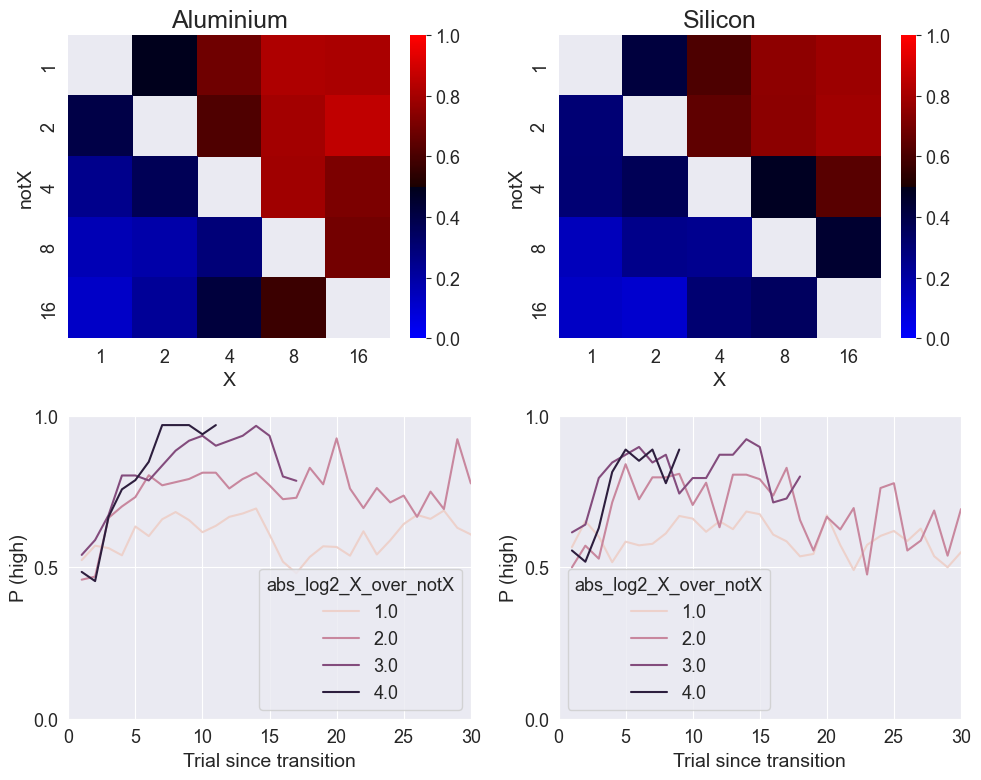

In [250]:
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.1),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1)

fig, axs = plt.subplots(2,2, figsize = (10,8), tight_layout = True)

for i in range(2):
    prot_values, prot_matrix = compute_probability_matrix(unibandits.query(f'animal == "{animal_list[i]}"'))
    sns.heatmap(ax = axs[0,i], data = prot_matrix, center = 0.5, cmap = blue_red1, vmin = 0, vmax = 1)
    axs[0,i].set_xlabel('X')
    axs[0,i].set_ylabel('notX')
    axs[0,i].set_title(f'{animal_list[i]}')
    axs[0,i].set_xticklabels(prot_values)
    axs[0,i].set_yticklabels(prot_values)


    sns.lineplot(ax = axs[1,i], data = probdf.query(f'animal == "{animal_list[i]}"'), x = 'valid_within_block', y = 'probability_high', hue = 'abs_log2_X_over_notX')
    axs[1,i].set_ylabel('P (high)')
    axs[1,i].set_xlabel('Trial since transition')
    axs[1,i].set_xlim(0,30)
    axs[1,i].set_ylim(0,1)
    axs[1,i].set_yticks((0,0.5, 1))


#fig.savefig(figureTargetFolder / "BehaviorAnalysis.pdf")

plt.show()

Example session, considering from the 2nd block onwards and only taking into account valid trials.

In [251]:
# example session
sessdf = unibandits.query(f'animal == "Aluminium" and date == 220603 and trial_type == "valid"')

sessdf['Xcount_previous_15_choices'] = np.nan

for ii in range(15, len(sessdf.index)-1):
    sessdf.loc[sessdf.index[ii], 'Xcount_previous_15_choices'] = list(sessdf.loc[sessdf.index[ii-15:ii], 'reward_pump'].values).count('X')

sessdf['probX_last15'] = sessdf.Xcount_previous_15_choices.apply(lambda x: x/15).astype(float)

egdf = sessdf.query('blockno > 1')
egdf['choice'] = egdf.probX_last15.apply(lambda x: (x-.5)*8)

#in this particular session there was a block transition in an aborted trial, so we plot the block change in the first valid trial 
invalid_index = unibandits.query('animal == "Aluminium" and date == 220603 and block_changed == True and trial_type != "valid"').index
egdf.loc[egdf.index[np.where(egdf.index > invalid_index[0])[0][0]], 'block_changed'] = True

egdf['rectangle_limit'] = egdf.log2_X_over_notX.apply(lambda x: x/8+.5)

#re-index the trial number, so that y axis is count of valid trials
egdf['trialno'] = egdf.reset_index().index

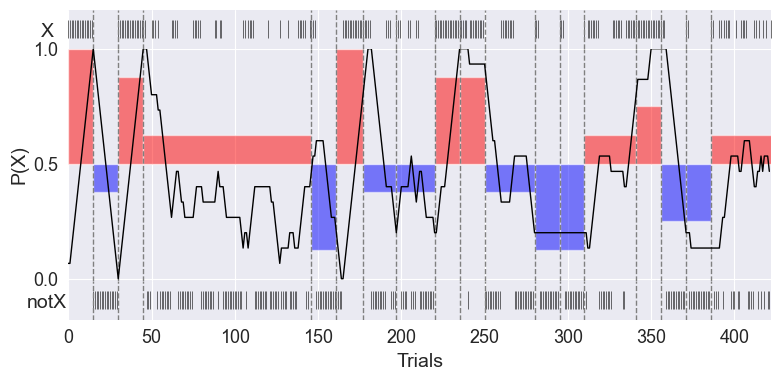

In [254]:
fig, axs = plt.subplots(3, tight_layout = True, gridspec_kw={'height_ratios': [1,6,1], 'hspace':0}, sharex = True, figsize = (8,4))

#block structure
for block in egdf.blockno.unique():
    height = egdf.query(f'blockno == {block}').rectangle_limit.unique()[0]
    start = int(egdf.query(f'blockno == {block}').trialno.values[0])
    end = int(egdf.query(f'blockno == {block}').trialno.values[-1])

    rectangle = mpl.patches.Rectangle((start, 0.5), end-start+1, height - 0.5, alpha = 0.5, facecolor = blue_red1(float(round(height))))
    axs[1].add_patch(rectangle)

    if start > 0:
        [axs[ii].axvline(start, color = 'grey', ls = 'dashed', lw = 1) for ii in range(3)]

# choices - raster plots
trials_X = egdf.query('reward_pump == "X"').trialno.unique()
trials_notX = egdf.query('reward_pump == "notX"').trialno.unique()

sns.scatterplot(ax = axs[0], x = trials_X, y = np.ones(len(trials_X)), marker = '|', color = 'black', s = 150, linewidth = .4)
sns.scatterplot(ax = axs[2], x = trials_notX, y = np.ones(len(trials_notX)), marker = '|', color = 'black', s = 150, linewidth = 0.4)

# running average fir choice in the last 15 trials
sns.lineplot(ax = axs[1], data = egdf, x = 'trialno', y = 'probX_last15', color = 'black', label = 'choice', lw = 1)

axs[2].set_xlabel('Trials')
axs[1].set_ylabel('P(X)')
axs[1].set_xlim(egdf.trialno.values[0], egdf.trialno.values[-1])
axs[1].set_ylim(-0.01,1)

axs[0].set_ylabel('X', rotation = 0)
axs[2].set_ylabel('notX', rotation = 0)

[axs[ii].yaxis.set_label_coords(-0.03,0.2) for ii in [0,2]]
[axs[ii].set_yticks([]) for ii in [0,2]]
axs[1].set_yticks([0,0.5,1])

axs[1].get_legend().remove()

sns.despine(fig = fig, top = True, bottom = True, right = True, left = True)

fig.savefig(figureTargetFolder / "BehaviorExampleSession.pdf")

plt.show()